# Yenisey River 2016 (pCO2) 
> https://arcticdata.io/catalog/view/doi%3A10.18739%2FA2V97ZR7H <br><br>
- Surface water was pumped into the equilibrators and headspace was sampled by Picarro CRDS (G2201i) analyzer. <br><br>
- Atmosphere was sampled by a Picarro CRDS (G2201i) analyzer placed 3m above the water. <br><br>
- Wind Speed, Wind Direction, Air Temperature, Humidity, and Barometric Pressure were measured with a weather station (Airmar 220WX) mounted at 10m hight. <br><br>
- Long Wave and Short Wave radiation was measured using Hukseflux SR11 pyranometer (short wave) and Hukseflux IR02 pyrgeometer (long wave) mounted 3m above water. <br><br>
- A High frequency temperature sensor (RBR duet) along with an ADCP (Teledyne Rio Grande workhorse, 600 kHz) to determine turbulent mixing in the surface waters. <br><br>
> - co2_w , ico2_w , ch4_w , ich4_w
> - co2_a , ico2_a , ch4_a , ich4_a
> - u , dir , t_air , rh , p_bar
> - lwr , swr


Contains pin averaged (1 min) concentration and isotopic composition of CO2 and CH4 in air

In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

# Change Directory
import os
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data') # Laptop @ J: # Desktop @ J:
print('-----------------------------------------------------')
print('WD: ', os.getcwd())
print('-----------------------------------------------------')
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("default") # notebook, paper, poster
%matplotlib inline
from matplotlib import ticker
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime
years  =  mdates.YearLocator()
months =  mdates.MonthLocator()
days   =  mdates.DayLocator()
hours  =  mdates.HourLocator()
month_name = DateFormatter("%b")
day_name = DateFormatter('%d')


from scipy.stats import zscore
import scipy.stats as stats

-----------------------------------------------------
WD:  J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data
-----------------------------------------------------


# Import Datasets

In [2]:
# Import Water Data (Amon_2016_Yenisei)
waterfile = 'Amon_2016_Yenisei_Water.txt'
water = pd.read_csv(waterfile, sep ='\t',  parse_dates=[0])
water.columns = water.columns.str.strip()
water.index = water['date_time']
water['year'] = pd.DatetimeIndex(water['date_time']).year
water['month'] = pd.DatetimeIndex(water['date_time']).month
water['day'] = pd.DatetimeIndex(water['date_time']).day
water['hour'] = pd.DatetimeIndex(water['date_time']).hour
water = water.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
water = water.dropna(how='any')

# Import Air Data (Amon_2016_Yenisei)
airfile = 'Amon_2016_Yenisei_Air.txt'
air = pd.read_csv(airfile, sep ='\t',  parse_dates=[0])
air.columns = air.columns.str.strip()
air.index = air['date_time']
air['year'] = pd.DatetimeIndex(air['date_time']).year
air['month'] = pd.DatetimeIndex(air['date_time']).month
air['day'] = pd.DatetimeIndex(air['date_time']).day
air['hour'] = pd.DatetimeIndex(air['date_time']).hour
air = air.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
air = air.dropna(how='any')

# Copies
water_raw = water.copy()
air_raw = air.copy()

### Functions



In [3]:
# Find Max/Min For a column and Show one other Columns
def find_min_max_1(dataframe, column_name):
    min_val, min_date = dataframe[column_name].min(), dataframe[column_name].idxmin()
    max_val, max_date = dataframe[column_name].max(), dataframe[column_name].idxmax()
    print(f"Min {column_name} @ {min_val} on {min_date}")
    print(f"Max {column_name} @ {max_val} on {max_date}")
    
# Find Max/Min For a column and Show two other Columns
def find_min_max_2(dataframe, primary_col, additional_col):
    """
    Find and print the minimum and maximum values of a specified column in a DataFrame, 
    along with the corresponding values of another column at those points.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to analyze.
    primary_col (str): The name of the primary column to find min and max values.
    additional_col (str): The name of the additional column for retrieving related values.

    Returns:
    None: This function prints the results and does not return a value.
    """
    # Find min and max of the primary column
    min_val, min_date = dataframe[primary_col].min(), dataframe[primary_col].idxmin()
    max_val, max_date  = dataframe[primary_col].max(), dataframe[primary_col].idxmax()
    # Retrieve values from the additional column at min and max dates
    additional_val_at_min = dataframe.loc[min_date, additional_col]
    additional_val_at_max = dataframe.loc[max_date, additional_col]
    print(f"Min {primary_col} @ {min_val} on {min_date} @ {additional_col}: {additional_val_at_min}")
    print(f"Max {primary_col} @ {max_val} on {max_date} @ {additional_col}: {additional_val_at_max}")

# Histograms
def plot_columns_single_row(df, columns, bins=51, alpha=0.7, sharey=True):
    """
    Plots histograms for specified columns in a DataFrame, all in a single row.

    :df: DataFrame containing the data.
    :columns: List of column names (str) to plot.
    :bins: Number of bins for the histogram.
    :alpha: Alpha blending value for the histogram.
    
    Returns:
    None: This function creates a plot but does not return any value.
    """
    num_cols = len(columns)
    fig, ax = plt.subplots(1, num_cols, figsize=(9, 3), sharey=sharey)

    ax[0].set_ylabel('Frequency', labelpad=20, fontsize=12)
    ax[0].yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12)
    
    for i, col in enumerate(columns):
        data = df[col]
        mean = data.mean()
        std = data.std()
        
        # Histogram plot
        counts, bins_array, patches = ax[i].hist(data, bins=bins, edgecolor='black', color='blue', alpha=alpha)

        # Find the bin with the maximum frequency
        max_count = counts.max()
        max_bin_index = counts.argmax()
        max_bin_value = bins_array[max_bin_index]

        # Add vertical and horizontal lines
        ax[i].axhline(y=max_count, color='r', linestyle='dashed', lw=1)
        ax[i].axvline(x=max_bin_value, color='r', linestyle='dashed', lw=1)

        ax[i].set_title(f'{col}', fontsize=16)
        ax[i].text(0.925, 0.95, f'μ: {mean:.1f}', fontsize=12, ha='right', va='top', 
                   transform=ax[i].transAxes)
        ax[i].text(0.925, 0.88, f'σ: {std:.1f}', fontsize=12, ha='right', va='top', 
                   transform=ax[i].transAxes)
        ax[i].xaxis.set_major_locator(MaxNLocator(6))
        ax[i].xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)

    plt.tight_layout(pad=0.5)
    plt.show()
    
    return fig, ax

In [4]:
# Folder to Save Images (# Laptop @ J: ##### Desktop @ J:)
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')

In [5]:
water.columns

Index(['date_time', 'ch4_w', 'ich4_w', 'co2_w', 'ico2_w', 'lat_w', 'lon_w',
       'sog_w', 'cog_w', 't_air_w', 'rh_w', 't_dew_w', 'p_rad_w', 'swr_w',
       'lwr_w', 't_rad_w', 'u_w', 'u_dir_w', 't_adcp_w', 'year', 'month',
       'day', 'hour'],
      dtype='object')

### Quick Plots

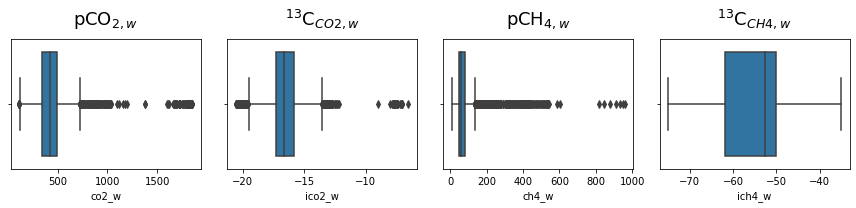

In [6]:
# Set figure and axes
fig, ax = plt.subplots(1,4,figsize =(12,3))

# Box plot
sns.boxplot(x=water['co2_w'], ax=ax[0])
sns.boxplot(x=water['ico2_w'], ax=ax[1])
sns.boxplot(x=water['ch4_w'], ax=ax[2])
sns.boxplot(x=water['ich4_w'], ax=ax[3])
# Titles
ax[0].set_title('pCO$_{2,w}$', fontsize=18, pad=15)
ax[1].set_title('$^{13}$C$_{CO2,w}$', fontsize=18, pad=15)
ax[2].set_title('pCH$_{4,w}$', fontsize=18, pad=15)
ax[3].set_title('$^{13}$C$_{CH4,w}$', fontsize=18, pad=15)
fig.tight_layout()

# CO2 Raw

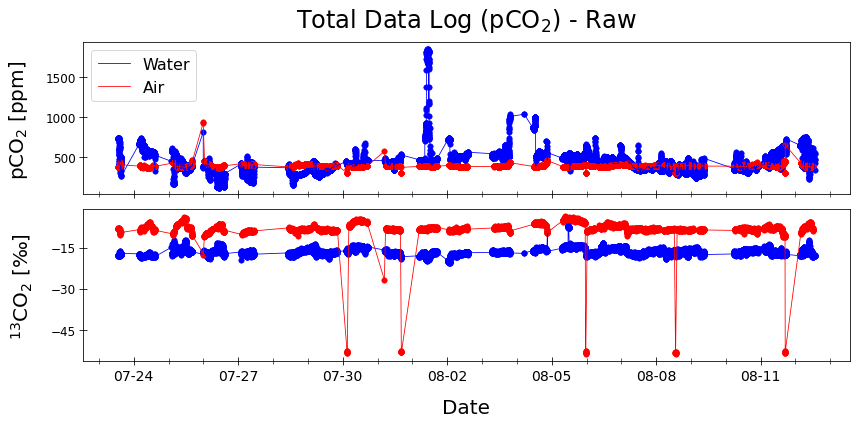

In [7]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
ax[0].set_title('Total Data Log (pCO$_{2}$) - Raw', color='black', fontsize=24, pad=15)
ax[0].set_ylabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=15)
ax[1].set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[1].set_xlabel('Date', color='black', fontsize=20, labelpad=15)

ax[0].plot(water.index, water['co2_w'], c = 'blue', lw=0.8, label="Water")  # pCO$_{2,water}$
ax[0].plot(air.index, air['co2_a'], c = 'red', lw=0.8, label="Air")         # pCO$_{2,air}$

ax[0].scatter(water.index, water['co2_w'], c = 'blue', lw=0.5, s=30)  
ax[0].scatter(air.index, air['co2_a'], c = 'red', lw=0.5, s=30)  

ax[1].plot(water.index, water['ico2_w'], c = 'blue', lw=0.8)  # $^{13}$CO$_{2,water}$
ax[1].plot(air.index, air['ico2_a'], c = 'red', lw=0.8)       # $^{13}$CO$_{2,air}$

ax[1].scatter(water.index, water['ico2_w'], c = 'blue', lw=0.5, s=30)  
ax[1].scatter(air.index, air['ico2_a'], c = 'red', lw=0.5, s=30)  

#ax[0].set_ylim([50, 1200])
#ax[1].set_ylim([-30, 0])
ax[0].legend(fontsize=16, loc='upper left') # bbox_to_anchor=(1.0, 1.00)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6)
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=12, color='black')
    ax.yaxis.set_major_locator(MaxNLocator(4)) 
    #ax.grid(axis='x',c='black',ls='--',lw='1',alpha=0.8)
    #ax.axvspan(datetime.date(2016,8,3), datetime.date(2016,8,4), alpha=0.15, color='black')
    
fig.tight_layout()

fig.savefig('Yenisey_EDA_Raw_co2_ico2_time.png', dpi = 600, bbox_inches='tight')

In [8]:
min_lat, min_date = water['lat_w'].min(), water['lat_w'].idxmin()
max_lat, max_date = water['lat_w'].max(), water['lat_w'].idxmax()
print(f"Min Latitude @ {min_lat}°N on {min_date}")
print(f"Max Latitude @ {max_lat}°N on {max_date}")

Min Latitude @ 56.23942553°N on 2016-07-23 13:08:00
Max Latitude @ 68.26089092°N on 2016-08-03 16:54:00


In [9]:
find_min_max_2(water, 'co2_w', 'lat_w')

Min co2_w @ 115.4005611 on 2016-07-26 10:33:00 @ lat_w: 60.000661
Max co2_w @ 1848.534844 on 2016-08-01 10:25:00 @ lat_w: 65.92985375


In [10]:
find_min_max_2(water, 'ch4_w', 'lat_w')

Min ch4_w @ 10.13067544 on 2016-08-10 11:34:00 @ lat_w: 60.41486542
Max ch4_w @ 957.6735933 on 2016-08-04 20:38:00 @ lat_w: 67.42359917


In [11]:
find_min_max_2(water, 'ich4_w', 'lat_w')

Min ich4_w @ -74.92845848 on 2016-07-29 14:20:00 @ lat_w: 62.46973467
Max ich4_w @ -35.14309202 on 2016-08-03 08:16:00 @ lat_w: 67.53483283


In [12]:
find_min_max_2(water, 't_adcp_w', 'lat_w')

Min t_adcp_w @ 8.231428571 on 2016-07-23 13:08:00 @ lat_w: 56.23942553
Max t_adcp_w @ 19.69766667 on 2016-08-08 10:10:00 @ lat_w: 62.29845575


In [13]:
find_min_max_2(water, 't_rad_w', 'lat_w')

Min t_rad_w @ 6.218230989 on 2016-08-03 18:46:00 @ lat_w: 68.0976635
Max t_rad_w @ 30.53379778 on 2016-07-24 07:47:00 @ lat_w: 57.15257833


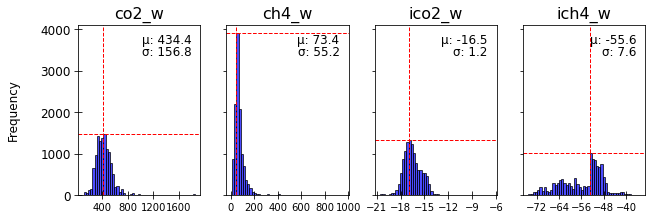

(<Figure size 648x216 with 4 Axes>,
 array([<AxesSubplot:title={'center':'co2_w'}, ylabel='Frequency'>,
        <AxesSubplot:title={'center':'ch4_w'}>,
        <AxesSubplot:title={'center':'ico2_w'}>,
        <AxesSubplot:title={'center':'ich4_w'}>], dtype=object))

In [14]:
plot_columns_single_row(water, ['co2_w', 'ch4_w', 'ico2_w', 'ich4_w'])

In [15]:
#print(water['co2_w'].describe())

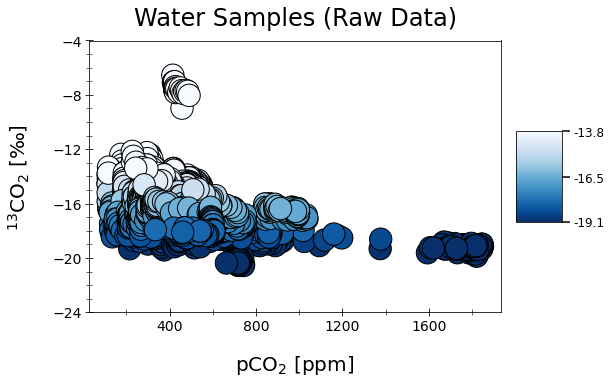

In [16]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Water Samples (Raw Data)', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = water['ico2_w'].quantile(0.01)
vmax = water['ico2_w'].quantile(0.99)
mean_value = water['ico2_w'].mean()

mappable = ax.scatter(water['co2_w'], water['ico2_w'], cmap = 'Blues_r', c = water['ico2_w'], 
                      edgecolor= 'black', lw=1.0, s=500, zorder=1,
                      vmin=vmin, vmax=vmax)

#ax.axvline(1200, color='grey', ls='--',lw=1.2)
#ax.axhline(-22, color='black', ls='--', lw=1.2)
#ax.axhline(-10, color='black', ls='--', lw=1.2)

#ax.set_xlim(-1,32)
ax.set_ylim(-24,-4)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(4))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CO$_{2}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('Yenisey_EDA_Raw_co2_ico2_water1.png', dpi = 600, bbox_inches='tight')

14.2, 16.5, 18.5 @ 98/2
13.8, 16.5, 19.1 @ 99/1

In [17]:
# Outliers (Z-Score) for CO2
# Determine the number of rows containing outliers
z_scores = np.abs(stats.zscore(water['co2_w']))
outlier_rows = np.where(z_scores > 3)[0]  # Indices of rows with outliers
num_outlier_rows = len(outlier_rows)
print(f"Number of rows containing outliers: {num_outlier_rows}")

Number of rows containing outliers: 122


In [18]:
outlier_rows

array([4521, 4522, 4523, 4524, 4525, 4526, 4550, 4551, 4552, 4553, 4554,
       4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4565,
       4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4576,
       4577, 4578, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587,
       4588, 4589, 4590, 4591, 4592, 4593, 4594, 4595, 4596, 4597, 4598,
       4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609,
       4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620,
       4621, 4622, 4623, 4624, 5856, 5857, 5858, 5859, 5860, 5861, 5862,
       5863, 5864, 5865, 5866, 5867, 5868, 5869, 5870, 5871, 5872, 5873,
       5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943,
       5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954,
       5955], dtype=int64)

<AxesSubplot:xlabel='date_time'>

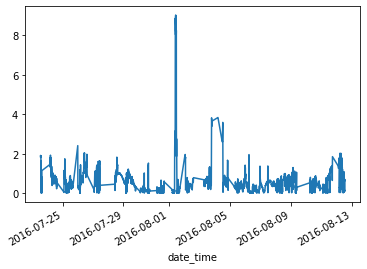

In [19]:
z_scores.plot()

In [20]:
# Outliers (IQR) for CO2
# Compute the 25th and 75th percentile value in `tenure`
percentile25 = water['co2_w'].quantile(0.25)
percentile75 = water['co2_w'].quantile(0.75)
# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25
# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)
# Identify subset of data containing outliers in `tenure`
outliers = water[(water['co2_w'] > upper_limit) | (water['co2_w'] < lower_limit)]
# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `co2_w`:", len(outliers))

Lower limit: 116.99620625
Upper limit: 722.95140185
Number of rows in the data containing outliers in `co2_w`: 301


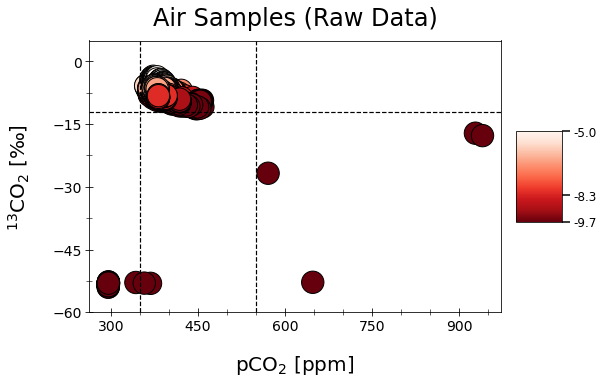

In [21]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Air Samples (Raw Data)', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = air['ico2_a'].quantile(0.05)
vmax = air['ico2_a'].quantile(0.95)
mean_value = air['ico2_a'].mean()

mappable = ax.scatter(air['co2_a'], air['ico2_a'], cmap = 'Reds_r', c = air['ico2_a'], 
                      edgecolor= 'black', lw=1.0, s=500, zorder=1, vmin=vmin, vmax=vmax)

ax.set_ylim(-60,5)
ax.axhline(-12, color='black', ls='--',lw=1.2)
ax.axvline(350, color='black', ls='--',lw=1.2)
ax.axvline(550, color='black', ls='--',lw=1.2)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CO$_{2}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('Yenisey_EDA_Raw_co2_ico2_air.png', dpi = 600, bbox_inches='tight')

# CH4 Raw

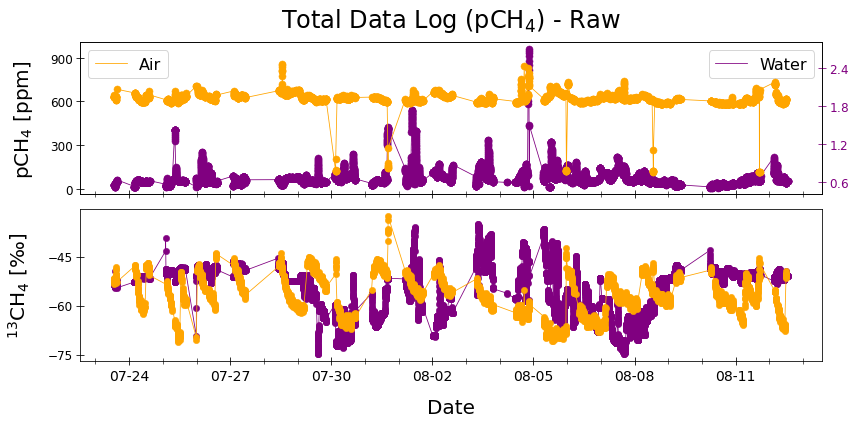

In [22]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
ax0 = ax[0].twinx()

ax[0].set_title('Total Data Log (pCH$_{4}$) - Raw', color='black', fontsize=24, pad=15)
ax[0].set_ylabel('pCH$_{4}$ [ppm] ', color='black', fontsize=20, labelpad=15)
ax[1].set_ylabel('$^{13}$CH$_{4}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[1].set_xlabel('Date', color='black', fontsize=20, labelpad=15)

ax[0].plot(water.index, water['ch4_w'], c = 'purple', lw=0.8, label="Water")  # pCO$_{2,water}$
ax0.plot(air.index, air['ch4_a'], c = 'orange', lw=0.8, label="Air")         # pCO$_{2,air}$

ax[0].scatter(water.index, water['ch4_w'], c = 'purple', lw=0.5, s=50)  
ax0.scatter(air.index, air['ch4_a'], c = 'orange', lw=0.5, s=50)  

ax[1].plot(water.index, water['ich4_w'], c = 'purple', lw=0.8, zorder=1)  # $^{13}$CO$_{2,water}$
ax[1].plot(air.index, air['ich4_a'], c = 'orange', lw=0.8, zorder=2)       # $^{13}$CO$_{2,air}$

ax[1].scatter(water.index, water['ich4_w'], c = 'purple', lw=0.5, s=40, zorder=1)  
ax[1].scatter(air.index, air['ich4_a'], c = 'orange', lw=0.5, s=40, zorder=2)  

#ax[0].set_ylim([50, 1200])
#ax[1].set_ylim([-30, 0])
ax[0].legend(loc='upper right', fontsize=16) # bbox_to_anchor=(1.0, 1.00) # , loc=1
ax0.legend(loc='upper left', fontsize=16) # bbox_to_anchor=(1.0, 1.00)
ax0.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12, color='purple') # color='red'
ax0.tick_params(axis='y', labelcolor='purple')
ax0.yaxis.set_major_locator(MaxNLocator(4))
ax0.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False, useMathText=True))
ax0.set_ylim(0.4, 2.8)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6)
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=12, color='black')
    ax.yaxis.set_major_locator(MaxNLocator(4)) 
    #ax.grid(axis='x',c='black',ls='--',lw='1',alpha=0.8)
    #ax.axvspan(datetime.date(2016,8,3), datetime.date(2016,8,4), alpha=0.15, color='black')
    
fig.tight_layout()

fig.savefig('Yenisey_EDA_Raw_ch4_ich4_time.png', dpi = 600, bbox_inches='tight')

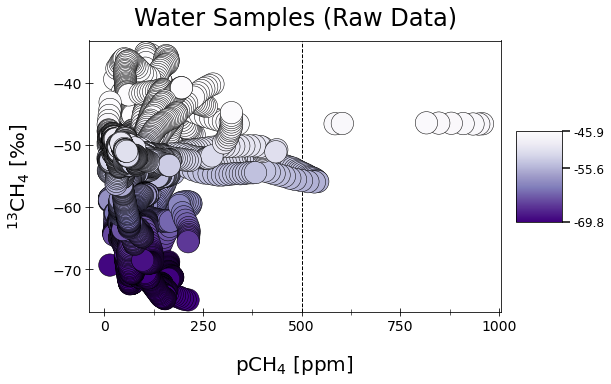

In [23]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Water Samples (Raw Data)', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCH$_{4}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CH$_{4}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = water['ich4_w'].quantile(0.05)
vmax = water['ich4_w'].quantile(0.95)
mean_value = water['ich4_w'].mean()

mappable = ax.scatter(water['ch4_w'], water['ich4_w'], cmap = 'Purples_r', c = water['ich4_w'], 
                      edgecolor= 'black', lw=0.5, s=500, zorder=1, vmin=vmin, vmax=vmax)

ax.axvline(500, color='black', ls='--',lw=1, zorder=0)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
#ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(4))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
#ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CH$_{4}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('Yenisey_EDA_Raw_ch4_ich4_water.png', dpi = 500, bbox_inches='tight')

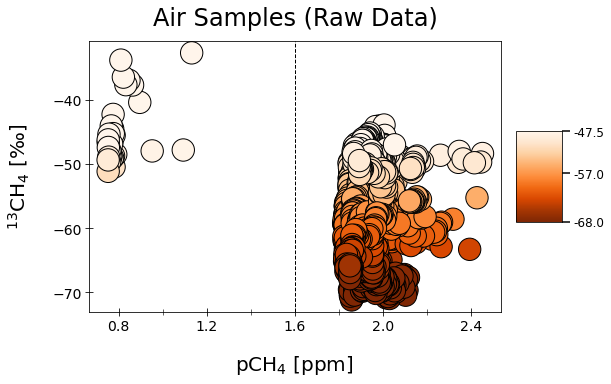

In [24]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Air Samples (Raw Data)', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCH$_{4}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CH$_{4}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = air['ich4_a'].quantile(0.05)
vmax = air['ich4_a'].quantile(0.95)
mean_value = air['ich4_a'].mean()

mappable = ax.scatter(air['ch4_a'], air['ich4_a'], cmap = 'Oranges_r', c = air['ich4_a'], edgecolor= 'black', 
                      lw=1.0, s=500, zorder=1, vmin=vmin, vmax=vmax)

# 
ax.axvline(1.6, color='black', ls='--',lw=1, zorder=0)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
#ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(4))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CH$_{4}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('Yenisey_EDA_Raw_ch4_ich4_air.png', dpi = 500, bbox_inches='tight')

<br><br>

# Remove Anomalies (Clean Data)

<br><br>

In [25]:
# Move Anomalies to a new dataframe
water_anomalies_co2_w = water[water['co2_w'] > 1197] # 1200
water_anomalies_ico2_w = water[water['ico2_w'] >= -10]
water_anomalies_ch4_w = water[water['ch4_w'] > 500]

air_anomalies_ico2_a = air[air['ico2_a'] <= -12]
air_anomalies_co2_a1 = air[air['co2_a'] > 550]
air_anomalies_co2_a2 = air[air['co2_a'] < 350]
air_anomalies_ch4_a = air[air['ch4_a'] < 1.6]

# Concatenate all the anomalies into a single dataframe
water_anomalies = pd.concat([water_anomalies_ico2_w, 
                             water_anomalies_ch4_w], axis=0)

air_anomalies = pd.concat([air_anomalies_ico2_a, air_anomalies_co2_a1, 
                           air_anomalies_co2_a2,air_anomalies_ch4_a], axis=0)

# Remove Anomalies from Origional Dataframe
water = water[~water.index.isin(water_anomalies_co2_w.index)]
water = water[~water.index.isin(water_anomalies_ico2_w.index)]
water = water[~water.index.isin(water_anomalies_ch4_w.index)]
air = air[~air.index.isin(air_anomalies_ico2_a.index)]
air = air[~air.index.isin(air_anomalies_co2_a1.index)]
air = air[~air.index.isin(air_anomalies_co2_a2.index)]
air = air[~air.index.isin(air_anomalies_ch4_a.index)]

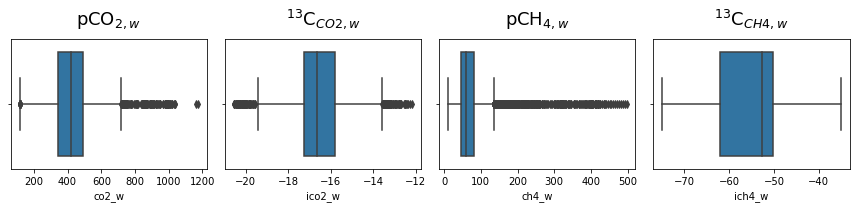

In [26]:
# Set figure and axes
fig, ax = plt.subplots(1,4,figsize =(12,3))

# Box plot
sns.boxplot(x=water['co2_w'], ax=ax[0])
sns.boxplot(x=water['ico2_w'], ax=ax[1])
sns.boxplot(x=water['ch4_w'], ax=ax[2])
sns.boxplot(x=water['ich4_w'], ax=ax[3])
# Titles
ax[0].set_title('pCO$_{2,w}$', fontsize=18, pad=15)
ax[1].set_title('$^{13}$C$_{CO2,w}$', fontsize=18, pad=15)
ax[2].set_title('pCH$_{4,w}$', fontsize=18, pad=15)
ax[3].set_title('$^{13}$C$_{CH4,w}$', fontsize=18, pad=15)
fig.tight_layout()

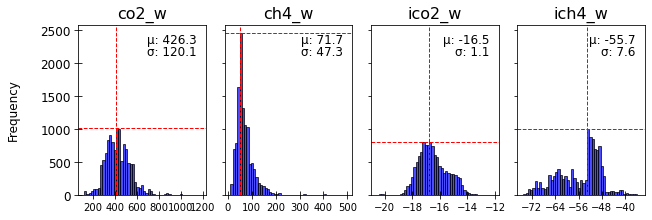

(<Figure size 648x216 with 4 Axes>,
 array([<AxesSubplot:title={'center':'co2_w'}, ylabel='Frequency'>,
        <AxesSubplot:title={'center':'ch4_w'}>,
        <AxesSubplot:title={'center':'ico2_w'}>,
        <AxesSubplot:title={'center':'ich4_w'}>], dtype=object))

In [27]:
plot_columns_single_row(water, ['co2_w', 'ch4_w', 'ico2_w', 'ich4_w'])

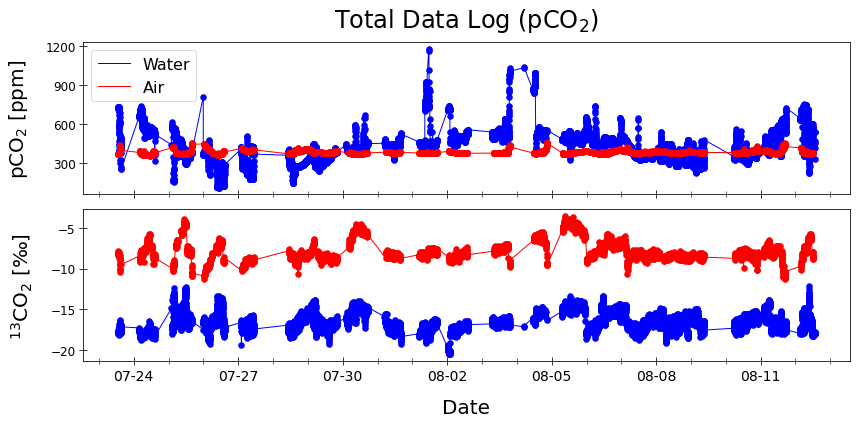

In [28]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
ax[0].set_title('Total Data Log (pCO$_{2}$)', color='black', fontsize=24, pad=15)
ax[0].set_ylabel('pCO$_{2}$ [ppm]', color='black', fontsize=20, labelpad=15)
ax[1].set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[1].set_xlabel('Date', color='black', fontsize=20, labelpad=15)

ax[0].plot(water.index, water['co2_w'], c = 'blue', lw=1, label="Water", zorder=0)  # pCO$_{2,water}$
ax[0].plot(air.index, air['co2_a'], c = 'red', lw=1, label="Air", zorder=1)         # pCO$_{2,air}$

ax[0].scatter(water.index, water['co2_w'], c = 'blue', lw=1, s=30, zorder=0)  
ax[0].scatter(air.index, air['co2_a'], c = 'red', lw=1, s=30, zorder=1)  

ax[1].plot(water.index, water['ico2_w'], c = 'blue', lw=1, zorder=0)  # $^{13}$CO$_{2,water}$
ax[1].plot(air.index, air['ico2_a'], c = 'red', lw=1, zorder=1)       # $^{13}$CO$_{2,air}$

ax[1].scatter(water.index, water['ico2_w'], c = 'blue', lw=1, s=30, zorder=0)  
ax[1].scatter(air.index, air['ico2_a'], c = 'red', lw=1, s=30, zorder=1)  

#ax[0].set_ylim([50, 1200])
#ax[1].set_ylim([-30, 0])
ax[0].legend(fontsize=16, loc='upper left') # bbox_to_anchor=(1.0, 1.00)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6)
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=12, color='black')
    ax.yaxis.set_major_locator(MaxNLocator(4)) 
    #ax.grid(axis='x',c='black',ls='--',lw='1',alpha=0.8)
    #ax.axvspan(datetime.date(2016,8,3), datetime.date(2016,8,4), alpha=0.15, color='black')
    
fig.tight_layout()
fig.savefig('Yenisey_EDA_Clean_co2_ico2_time.png', dpi = 500, bbox_inches='tight')

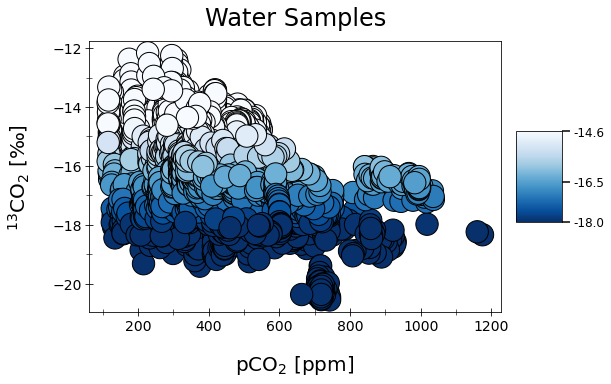

In [29]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Water Samples', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = water['ico2_w'].quantile(0.05)
vmax = water['ico2_w'].quantile(0.95)
mean_value = water['ico2_w'].mean()

mappable = ax.scatter(water['co2_w'], water['ico2_w'], cmap = 'Blues_r', c = water['ico2_w'], 
                      edgecolor= 'black', lw=1.0, s=500, zorder=1,
                      vmin=vmin, vmax=vmax)

#ax.set_xlim(-1,32)
#ax.set_ylim(-24,-4)

ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CO$_{2}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('Yenisey_EDA_Clean_co2_ico2_water.png', dpi = 500, bbox_inches='tight')

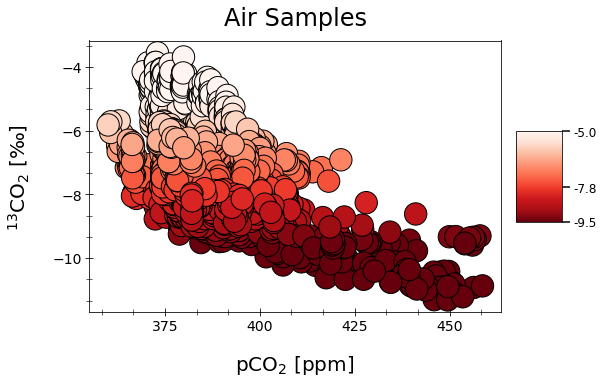

In [30]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Air Samples', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCO$_{2}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CO$_{2}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = air['ico2_a'].quantile(0.05)
vmax = air['ico2_a'].quantile(0.95)
mean_value = air['ico2_a'].mean()

mappable = ax.scatter(air['co2_a'], air['ico2_a'], cmap = 'Reds_r', c = air['ico2_a'], 
                      edgecolor= 'black', lw=1.0, s=500, zorder=1, vmin=vmin, vmax=vmax)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(3))
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CO$_{2}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('Yenisey_EDA_Clean_co2_ico2_air.png', dpi = 500, bbox_inches='tight')

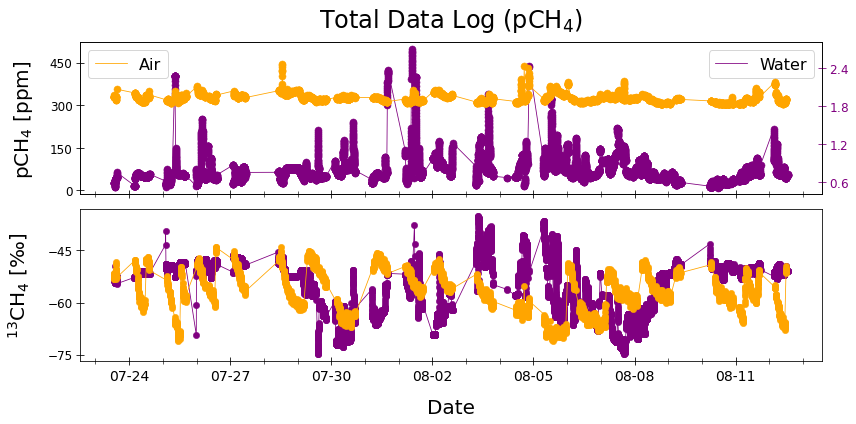

In [31]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
ax0 = ax[0].twinx()

ax[0].set_title('Total Data Log (pCH$_{4}$)', color='black', fontsize=24, pad=15)
ax[0].set_ylabel('pCH$_{4}$ [ppm] ', color='black', fontsize=20, labelpad=15)
ax[1].set_ylabel('$^{13}$CH$_{4}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[1].set_xlabel('Date', color='black', fontsize=20, labelpad=15)

ax[0].plot(water.index, water['ch4_w'], c = 'purple', lw=0.8, label="Water")  # pCO$_{2,water}$
ax0.plot(air.index, air['ch4_a'], c = 'orange', lw=0.8, label="Air")         # pCO$_{2,air}$

ax[0].scatter(water.index, water['ch4_w'], c = 'purple', lw=0.5, s=50)  
ax0.scatter(air.index, air['ch4_a'], c = 'orange', lw=0.5, s=50)  

ax[1].plot(water.index, water['ich4_w'], c = 'purple', lw=0.8, zorder=1)  # $^{13}$CO$_{2,water}$
ax[1].plot(air.index, air['ich4_a'], c = 'orange', lw=0.8, zorder=2)       # $^{13}$CO$_{2,air}$

ax[1].scatter(water.index, water['ich4_w'], c = 'purple', lw=0.5, s=40, zorder=1)  
ax[1].scatter(air.index, air['ich4_a'], c = 'orange', lw=0.5, s=40, zorder=2)  

#ax[0].set_ylim([50, 1200])
#ax[1].set_ylim([-30, 0])
ax[0].legend(loc='upper right', fontsize=16) # bbox_to_anchor=(1.0, 1.00) # , loc=1
ax0.legend(loc='upper left', fontsize=16) # bbox_to_anchor=(1.0, 1.00)
ax0.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12, color='purple') # color='red'
ax0.tick_params(axis='y', labelcolor='purple')
ax0.yaxis.set_major_locator(MaxNLocator(4))
ax0.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False, useMathText=True))
ax0.set_ylim(0.4, 2.8)

for ax in ax:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6)
    ax.yaxis.set_tick_params(which='major', direction='inout',length=8, labelsize=12, color='black')
    ax.yaxis.set_major_locator(MaxNLocator(4)) 
    #ax.grid(axis='x',c='black',ls='--',lw='1',alpha=0.8)
    #ax.axvspan(datetime.date(2016,8,3), datetime.date(2016,8,4), alpha=0.15, color='black')
    
fig.tight_layout()
fig.savefig('Yenisey_EDA_Clean_ch4_ich4_time.png', dpi = 500, bbox_inches='tight')

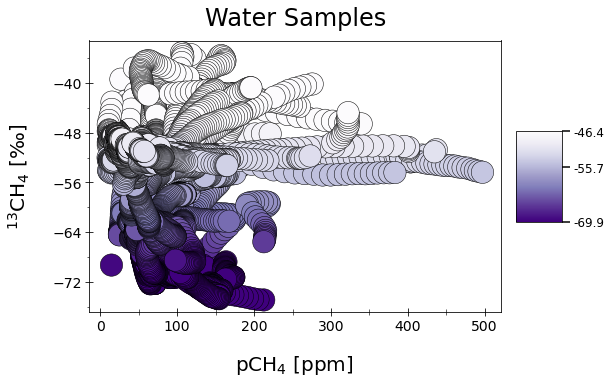

In [32]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Water Samples', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCH$_{4}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CH$_{4}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = water['ich4_w'].quantile(0.05)
vmax = water['ich4_w'].quantile(0.95)
mean_value = water['ich4_w'].mean()

mappable = ax.scatter(water['ch4_w'], water['ich4_w'], cmap = 'Purples_r', c = water['ich4_w'], 
                      edgecolor= 'black', lw=0.5, s=500, zorder=1, vmin=vmin, vmax=vmax)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
#ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CH$_{4}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('Yenisey_EDA_Clean_ch4_ich4_water.png', dpi = 500, bbox_inches='tight')

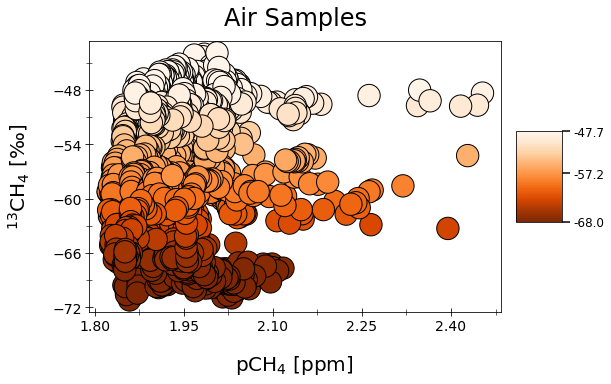

In [33]:
fig, ax = plt.subplots(figsize=(9,5))

ax.set_title('Air Samples', fontsize=24, c='black', pad=15)
ax.set_xlabel('pCH$_{4}$ [ppm] ', color='black', fontsize=20, labelpad=20)
ax.set_ylabel('$^{13}$CH$_{4}$ [‰]', color='black', fontsize=20, labelpad=20)

# Calculate vmin, vmax, and mean
vmin = air['ich4_a'].quantile(0.05)
vmax = air['ich4_a'].quantile(0.95)
mean_value = air['ich4_a'].mean()

mappable = ax.scatter(air['ch4_a'], air['ich4_a'], cmap = 'Oranges_r', c = air['ich4_a'], edgecolor= 'black', 
                      lw=1.0, s=500, zorder=1, vmin=vmin, vmax=vmax)

ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.xaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.yaxis.set_tick_params(direction='inout',length=8,labelsize=14)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=14)

# Use an explicit colorbar instead of "fig.colorbar"
cb = plt.colorbar(mappable, ax=ax, pad=0.03, aspect=2, shrink=0.333) # label='$^{13}$CH$_{4}$ [‰]'
cb.set_ticks([vmin, mean_value, vmax])
cb.set_ticklabels(['{:.1f}'.format(vmin), '{:.1f}'.format(mean_value), '{:.1f}'.format(vmax)])
cb.ax.tick_params(axis='y', which='major', length=8, width=1.5, labelsize=12) # Change size, length, and width as desired
#cb.set_ticks(ax.get_yticks())

fig.savefig('Yenisey_EDA_Clean_ch4_ich4_air.png', dpi = 500, bbox_inches='tight')

# Quick Correlation Matrix

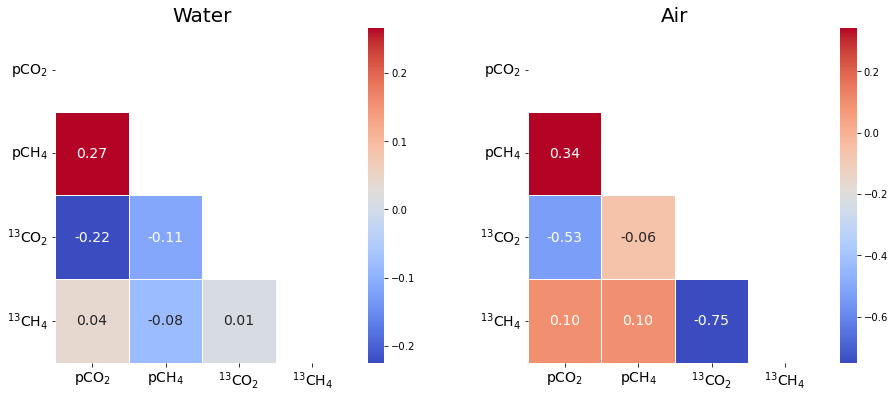

In [34]:
water_new = water[['co2_w','ch4_w', 'ico2_w', 'ich4_w']]
air_new = air[['co2_a', 'ch4_a', 'ico2_a', 'ich4_a']]

# Rename Columns
water_new.columns = ['pCO$_{2}$', 'pCH$_{4}$', '$^{13}$CO$_{2}$', '$^{13}$CH$_{4}$']
air_new.columns = ['pCO$_{2}$', 'pCH$_{4}$', '$^{13}$CO$_{2}$', '$^{13}$CH$_{4}$']
# Calculate the correlation matrix for the entire DataFrame
correlation_matrix_water = water_new.corr()
correlation_matrix_air = air_new.corr()

# Create a mask for the upper triangle
mask_water = np.triu(np.ones_like(correlation_matrix_water, dtype=bool))
mask_air = np.triu(np.ones_like(correlation_matrix_air, dtype=bool))

# Creating the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Water heatmap
sns.heatmap(correlation_matrix_water, mask=mask_water, ax=ax[0], 
            annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 14})
ax[0].set_title('Water', fontsize=20)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14, rotation=0)

# Air heatmap
sns.heatmap(correlation_matrix_air, mask=mask_air, ax=ax[1], 
            annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 14})
ax[1].set_title('Air', fontsize=20)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14, rotation=0)

fig.tight_layout(pad=6)

fig.savefig('Yenisey_EDA_Clean_correlation_matrix_1.png', dpi = 500, bbox_inches='tight')

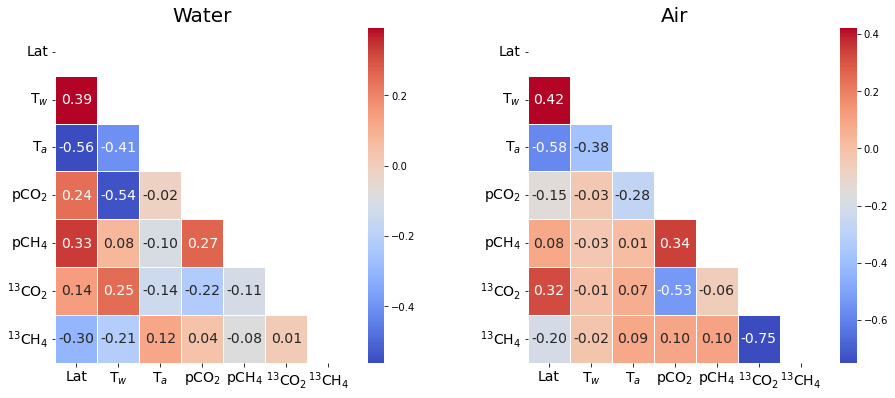

In [35]:
water_new = water[['lat_w', 't_adcp_w', 't_rad_w', 'co2_w','ch4_w', 'ico2_w', 'ich4_w']]
air_new = air[['lat_a', 't_adcp_a', 't_rad_a', 'co2_a', 'ch4_a', 'ico2_a', 'ich4_a']]

# Rename Columns
water_new.columns = ['Lat', 'T$_{w}$', 'T$_{a}$','pCO$_{2}$', 'pCH$_{4}$', 
                     '$^{13}$CO$_{2}$', '$^{13}$CH$_{4}$']
air_new.columns = ['Lat', 'T$_{w}$', 'T$_{a}$', 'pCO$_{2}$', 'pCH$_{4}$', 
                   '$^{13}$CO$_{2}$', '$^{13}$CH$_{4}$']

# Calculate the correlation matrix for the entire DataFrame
correlation_matrix_water = water_new.corr()
correlation_matrix_air = air_new.corr()

# Create a mask for the upper triangle
mask_water = np.triu(np.ones_like(correlation_matrix_water, dtype=bool))
mask_air = np.triu(np.ones_like(correlation_matrix_air, dtype=bool))

# Creating the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Water heatmap
sns.heatmap(correlation_matrix_water, mask=mask_water, ax=ax[0], 
            annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 14})
ax[0].set_title('Water', fontsize=20)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14, rotation=0)

# Air heatmap
sns.heatmap(correlation_matrix_air, mask=mask_air, ax=ax[1], 
            annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 14})
ax[1].set_title('Air', fontsize=20)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14, rotation=0)

fig.tight_layout(pad=6)

fig.savefig('Yenisey_EDA_Clean_correlation_matrix_2.png', dpi = 500, bbox_inches='tight')

### Notes:

In water and air, 
- pCO2 and Water Temperature are inversely related
- pCO2 and pCH4 are positively related.  <br>

In water, 
- Latitude and Water Temperature showed influence for all species <br>


In air, 
- 13C_CO2 and 13C_CH4 are positively related <br>



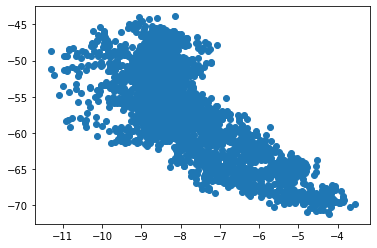

In [36]:
plt.scatter(air['ico2_a'], air['ich4_a'])

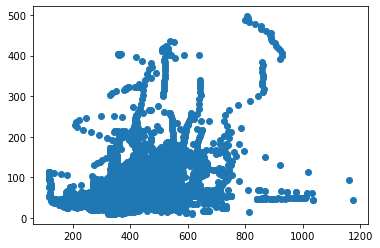

In [37]:
plt.scatter(water['co2_w'], water['ch4_w'])

In [38]:
find_min_max_2(water, 'co2_w', 'lat_w')
print()
find_min_max_2(water, 'ch4_w', 'lat_w')
print()
find_min_max_2(water, 'ico2_w', 'lat_w')
print()
find_min_max_2(water, 'ich4_w', 'lat_w')

Min co2_w @ 115.4005611 on 2016-07-26 10:33:00 @ lat_w: 60.000661
Max co2_w @ 1174.795374 on 2016-08-01 11:14:00 @ lat_w: 65.93126642

Min ch4_w @ 10.13067544 on 2016-08-10 11:34:00 @ lat_w: 60.41486542
Max ch4_w @ 497.0617244 on 2016-08-01 09:25:00 @ lat_w: 65.93264425

Min ico2_w @ -20.55717928 on 2016-08-02 01:20:00 @ lat_w: 66.49677992
Max ico2_w @ -12.15723954 on 2016-08-12 09:09:00 @ lat_w: 58.13089281

Min ich4_w @ -74.92845848 on 2016-07-29 14:20:00 @ lat_w: 62.46973467
Max ich4_w @ -35.14309202 on 2016-08-03 08:16:00 @ lat_w: 67.53483283


<br><br>

# Separating the Data

- Air (dfa) and Surface Water (dfw) measurements were collected during a cruise up and down the Yenisey River. The data will be separated into two sections: downstream (df1) and upsteam (df2).

<br><br>

In [39]:
# Transect I
df1w = water_raw.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
df1a = air_raw.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 

# Transect II
df2w = water_raw.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']
df2a = air_raw.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']

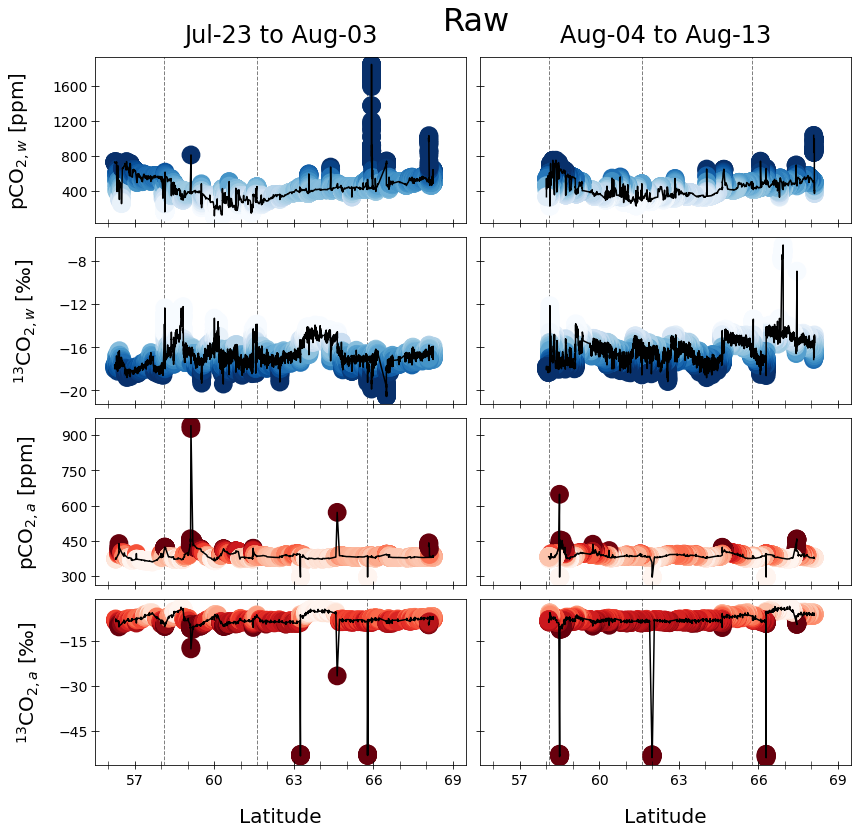

In [40]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")

ax[0,0].plot(df1w['lat_w'], df1w['co2_w'], c = 'black', lw=1.5)
ax[1,0].plot(df1w['lat_w'], df1w['ico2_w'], c = 'black', lw=1.5)
ax[2,0].plot(df1a['lat_a'], df1a['co2_a'], c = 'black', lw=1.5)
ax[3,0].plot(df1a['lat_a'], df1a['ico2_a'], c = 'black', lw=1.5)

ax[0,1].plot(df2w['lat_w'], df2w['co2_w'], c = 'black', lw=1.5)
ax[1,1].plot(df2w['lat_w'], df2w['ico2_w'], c = 'black', lw=1.5)
ax[2,1].plot(df2a['lat_a'], df2a['co2_a'], c = 'black', lw=1.5)
ax[3,1].plot(df2a['lat_a'], df2a['ico2_a'], c = 'black', lw=1.5)

ax[0,0].scatter(df1w['lat_w'], df1w['co2_w'], cmap = 'Blues', c = df1w['co2_w'], 
                lw=1.5, s=300, label="pCO$_{2,water}$", 
                vmin=df1w['co2_w'].quantile(0.05), 
                vmax=df1w['co2_w'].quantile(0.95))

ax[1,0].scatter(df1w['lat_w'], df1w['ico2_w'], cmap = 'Blues_r', c = df1w['ico2_w'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df1w['ico2_w'].quantile(0.05), 
                vmax=df1w['ico2_w'].quantile(0.95))

ax[2,0].scatter(df1a['lat_a'], df1a['co2_a'], cmap = 'Reds', c = df1a['co2_a'], 
                lw=1.5, s=300, label="pCO$_{2,air}$",
                vmin=df1a['co2_a'].quantile(0.05), 
                vmax=df1a['co2_a'].quantile(0.95))

ax[3,0].scatter(df1a['lat_a'], df1a['ico2_a'], cmap = 'Reds_r', c = df1a['ico2_a'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df1a['ico2_a'].quantile(0.05), 
                vmax=df1a['ico2_a'].quantile(0.95))

ax[0,1].scatter(df2w['lat_w'], df2w['co2_w'], cmap = 'Blues', c = df2w['co2_w'], 
                lw=1.5, s=300, label="pCO$_{2,water}$", 
                vmin=df2w['co2_w'].quantile(0.05), 
                vmax=df2w['co2_w'].quantile(0.95))

ax[1,1].scatter(df2w['lat_w'], df2w['ico2_w'], cmap = 'Blues_r', c = df2w['ico2_w'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df2w['ico2_w'].quantile(0.05), 
                vmax=df2w['ico2_w'].quantile(0.95))

ax[2,1].scatter(df2a['lat_a'], df2a['co2_a'], cmap = 'Reds', c = df2a['co2_a'], 
                lw=1.5, s=300, label="pCO$_{2,air}$",
                vmin=df2a['co2_a'].quantile(0.05), 
                vmax=df2a['co2_a'].quantile(0.95))

ax[3,1].scatter(df2a['lat_a'], df2a['ico2_a'], cmap = 'Reds_r', c = df2a['ico2_a'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df2a['ico2_a'].quantile(0.05), 
                vmax=df2a['ico2_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCO$_{2,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCO$_{2,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CO$_{2,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CO$_{2,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
    #ax.axvline(66.488333, color='grey', ls='--', lw=1, zorder=0)  # Kureyka
    #ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.suptitle('Raw', fontsize=32, x=0.555, y=0.96)

fig.tight_layout(pad=1)

fig.savefig('Yenisey_EDA_Raw_co2_Latitude.png', dpi = 600, bbox_inches='tight')

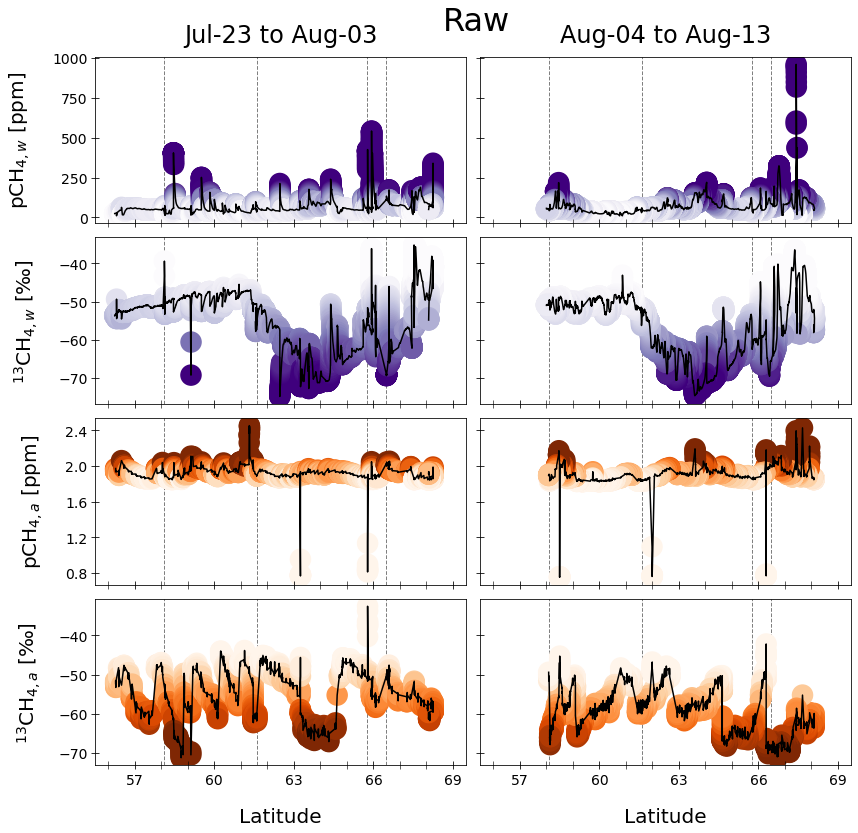

In [41]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")

ax[0,0].plot(df1w['lat_w'], df1w['ch4_w'], c = 'black', lw=1.5)
ax[1,0].plot(df1w['lat_w'], df1w['ich4_w'], c = 'black', lw=1.5)
ax[2,0].plot(df1a['lat_a'], df1a['ch4_a'], c = 'black', lw=1.5)
ax[3,0].plot(df1a['lat_a'], df1a['ich4_a'], c = 'black', lw=1.5)

ax[0,1].plot(df2w['lat_w'], df2w['ch4_w'], c = 'black', lw=1.5)
ax[1,1].plot(df2w['lat_w'], df2w['ich4_w'], c = 'black', lw=1.5)
ax[2,1].plot(df2a['lat_a'], df2a['ch4_a'], c = 'black', lw=1.5)
ax[3,1].plot(df2a['lat_a'], df2a['ich4_a'], c = 'black', lw=1.5)

ax[0,0].scatter(df1w['lat_w'], df1w['ch4_w'], cmap = 'Purples', c = df1w['ch4_w'], 
                lw=1.5, s=400, label="pCO$_{2,water}$", 
                vmin=df1w['ch4_w'].quantile(0.05), 
                vmax=df1w['ch4_w'].quantile(0.95))

ax[1,0].scatter(df1w['lat_w'], df1w['ich4_w'], cmap = 'Purples_r', c = df1w['ich4_w'], 
                lw=1.5, s=400, label="$^{13}$CH$_{4,water}$",
                vmin=df1w['ich4_w'].quantile(0.05), 
                vmax=df1w['ich4_w'].quantile(0.95))

ax[2,0].scatter(df1a['lat_a'], df1a['ch4_a'], cmap = 'Oranges', c = df1a['ch4_a'], 
                lw=1.5, s=400, label="pCO$_{2,air}$",
                vmin=df1a['ch4_a'].quantile(0.05), 
                vmax=df1a['ch4_a'].quantile(0.95))

ax[3,0].scatter(df1a['lat_a'], df1a['ich4_a'], cmap = 'Oranges_r', c = df1a['ich4_a'], 
                lw=1.5, s=400, label="$^{13}$CH$_{4,air}$",
                vmin=df1a['ich4_a'].quantile(0.05), 
                vmax=df1a['ich4_a'].quantile(0.95))

ax[0,1].scatter(df2w['lat_w'], df2w['ch4_w'], cmap = 'Purples', c = df2w['ch4_w'], 
                lw=1.5, s=400, label="pCO$_{2,water}$", 
                vmin=df2w['ch4_w'].quantile(0.05), 
                vmax=df2w['ch4_w'].quantile(0.95))

ax[1,1].scatter(df2w['lat_w'], df2w['ich4_w'], cmap = 'Purples_r', c = df2w['ich4_w'], 
                lw=1.5, s=400, label="$^{13}$CH$_{4,water}$",
                vmin=df2w['ich4_w'].quantile(0.05), 
                vmax=df2w['ich4_w'].quantile(0.95))

ax[2,1].scatter(df2a['lat_a'], df2a['ch4_a'], cmap = 'Oranges', c = df2a['ch4_a'], 
                lw=1.5, s=400, label="pCO$_{2,air}$",
                vmin=df2a['ch4_a'].quantile(0.05), 
                vmax=df2a['ch4_a'].quantile(0.95))

ax[3,1].scatter(df2a['lat_a'], df2a['ich4_a'], cmap = 'Oranges_r', c = df2a['ich4_a'], 
                lw=1.5, s=400, label="$^{13}$CH$_{4,air}$",
                vmin=df2a['ich4_a'].quantile(0.05), 
                vmax=df2a['ich4_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCH$_{4,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCH$_{4,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CH$_{4,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CH$_{4,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
    ax.axvline(66.488333, color='grey', ls='--', lw=1, zorder=0)  # Kureyka
    #ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.suptitle('Raw', fontsize=32, x=0.555, y=0.96)
fig.tight_layout(pad=1)

fig.savefig('Yenisey_EDA_Raw_ch4_Latitude.png', dpi = 600, bbox_inches='tight')

In [42]:
# Transect I
df1w = water.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 
df1a = air.loc['2016-07-23 00:00:00':'2016-08-04 00:00:00'] 

# Transect II
df2w = water.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']
df2a = air.loc['2016-08-04 00:00:00':'2016-08-13 00:00:00']

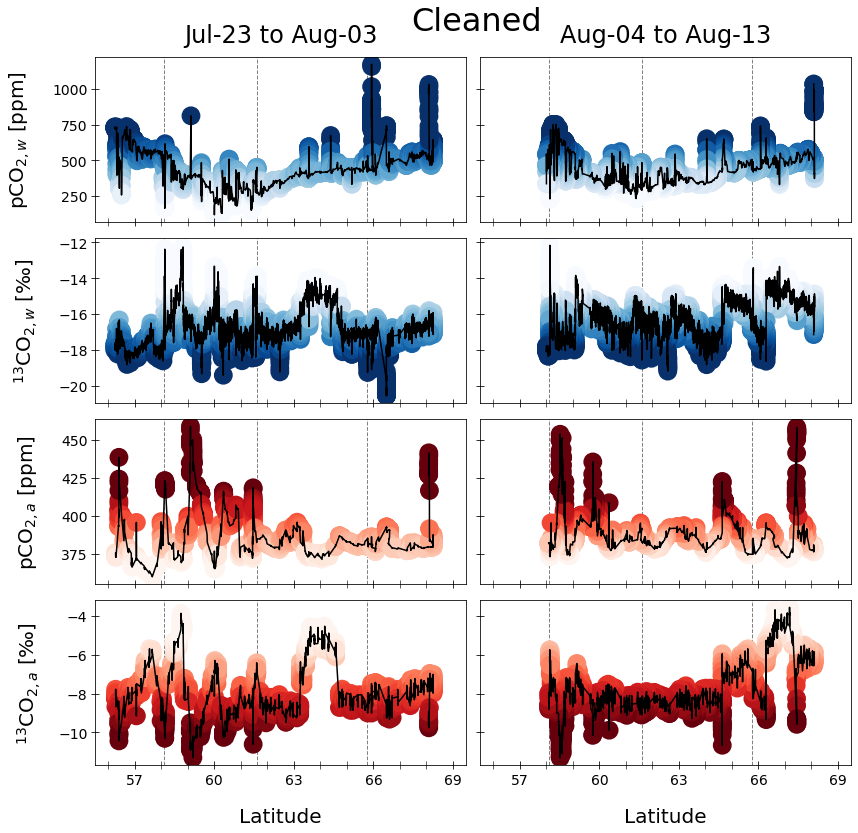

In [43]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")

ax[0,0].plot(df1w['lat_w'], df1w['co2_w'], c = 'black', lw=1.5)
ax[1,0].plot(df1w['lat_w'], df1w['ico2_w'], c = 'black', lw=1.5)
ax[2,0].plot(df1a['lat_a'], df1a['co2_a'], c = 'black', lw=1.5)
ax[3,0].plot(df1a['lat_a'], df1a['ico2_a'], c = 'black', lw=1.5)

ax[0,1].plot(df2w['lat_w'], df2w['co2_w'], c = 'black', lw=1.5)
ax[1,1].plot(df2w['lat_w'], df2w['ico2_w'], c = 'black', lw=1.5)
ax[2,1].plot(df2a['lat_a'], df2a['co2_a'], c = 'black', lw=1.5)
ax[3,1].plot(df2a['lat_a'], df2a['ico2_a'], c = 'black', lw=1.5)

ax[0,0].scatter(df1w['lat_w'], df1w['co2_w'], cmap = 'Blues', c = df1w['co2_w'], 
                lw=1.5, s=300, label="pCO$_{2,water}$", 
                vmin=df1w['co2_w'].quantile(0.05), 
                vmax=df1w['co2_w'].quantile(0.95))

ax[1,0].scatter(df1w['lat_w'], df1w['ico2_w'], cmap = 'Blues_r', c = df1w['ico2_w'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df1w['ico2_w'].quantile(0.05), 
                vmax=df1w['ico2_w'].quantile(0.95))

ax[2,0].scatter(df1a['lat_a'], df1a['co2_a'], cmap = 'Reds', c = df1a['co2_a'], 
                lw=1.5, s=300, label="pCO$_{2,air}$",
                vmin=df1a['co2_a'].quantile(0.05), 
                vmax=df1a['co2_a'].quantile(0.95))

ax[3,0].scatter(df1a['lat_a'], df1a['ico2_a'], cmap = 'Reds_r', c = df1a['ico2_a'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df1a['ico2_a'].quantile(0.05), 
                vmax=df1a['ico2_a'].quantile(0.95))

ax[0,1].scatter(df2w['lat_w'], df2w['co2_w'], cmap = 'Blues', c = df2w['co2_w'], 
                lw=1.5, s=300, label="pCO$_{2,water}$", 
                vmin=df2w['co2_w'].quantile(0.05), 
                vmax=df2w['co2_w'].quantile(0.95))

ax[1,1].scatter(df2w['lat_w'], df2w['ico2_w'], cmap = 'Blues_r', c = df2w['ico2_w'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df2w['ico2_w'].quantile(0.05), 
                vmax=df2w['ico2_w'].quantile(0.95))

ax[2,1].scatter(df2a['lat_a'], df2a['co2_a'], cmap = 'Reds', c = df2a['co2_a'], 
                lw=1.5, s=300, label="pCO$_{2,air}$",
                vmin=df2a['co2_a'].quantile(0.05), 
                vmax=df2a['co2_a'].quantile(0.95))

ax[3,1].scatter(df2a['lat_a'], df2a['ico2_a'], cmap = 'Reds_r', c = df2a['ico2_a'], 
                lw=1.5, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df2a['ico2_a'].quantile(0.05), 
                vmax=df2a['ico2_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCO$_{2,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCO$_{2,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CO$_{2,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CO$_{2,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
    #ax.axvline(66.488333, color='grey', ls='--', lw=1, zorder=0)  # Kureyka
    #ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.suptitle('Cleaned', fontsize=32, x=0.555, y=0.96)
fig.tight_layout(pad=1)

fig.savefig('Yenisey_EDA_Clean_co2_Latitude.png', dpi = 600, bbox_inches='tight')

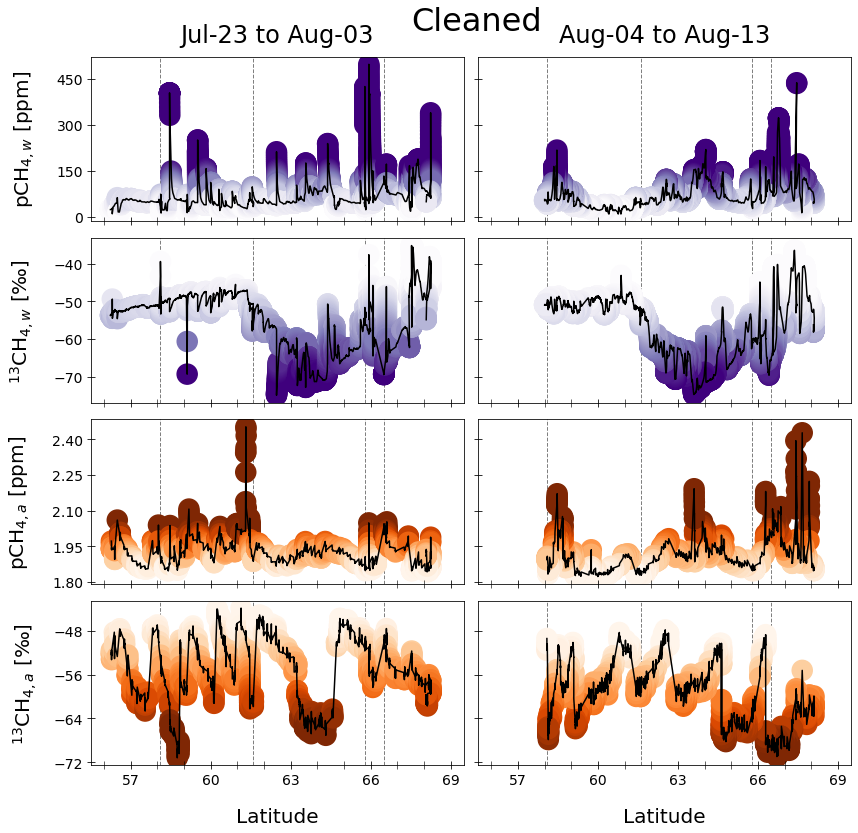

In [44]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")

ax[0,0].plot(df1w['lat_w'], df1w['ch4_w'], c = 'black', lw=1.5)
ax[1,0].plot(df1w['lat_w'], df1w['ich4_w'], c = 'black', lw=1.5)
ax[2,0].plot(df1a['lat_a'], df1a['ch4_a'], c = 'black', lw=1.5)
ax[3,0].plot(df1a['lat_a'], df1a['ich4_a'], c = 'black', lw=1.5)

ax[0,1].plot(df2w['lat_w'], df2w['ch4_w'], c = 'black', lw=1.5)
ax[1,1].plot(df2w['lat_w'], df2w['ich4_w'], c = 'black', lw=1.5)
ax[2,1].plot(df2a['lat_a'], df2a['ch4_a'], c = 'black', lw=1.5)
ax[3,1].plot(df2a['lat_a'], df2a['ich4_a'], c = 'black', lw=1.5)

ax[0,0].scatter(df1w['lat_w'], df1w['ch4_w'], cmap = 'Purples', c = df1w['ch4_w'], 
                lw=1.5, s=400, label="pCO$_{2,water}$", 
                vmin=df1w['ch4_w'].quantile(0.05), 
                vmax=df1w['ch4_w'].quantile(0.95))

ax[1,0].scatter(df1w['lat_w'], df1w['ich4_w'], cmap = 'Purples_r', c = df1w['ich4_w'], 
                lw=1.5, s=400, label="$^{13}$CH$_{4,water}$",
                vmin=df1w['ich4_w'].quantile(0.05), 
                vmax=df1w['ich4_w'].quantile(0.95))

ax[2,0].scatter(df1a['lat_a'], df1a['ch4_a'], cmap = 'Oranges', c = df1a['ch4_a'], 
                lw=1.5, s=400, label="pCO$_{2,air}$",
                vmin=df1a['ch4_a'].quantile(0.05), 
                vmax=df1a['ch4_a'].quantile(0.95))

ax[3,0].scatter(df1a['lat_a'], df1a['ich4_a'], cmap = 'Oranges_r', c = df1a['ich4_a'], 
                lw=1.5, s=400, label="$^{13}$CH$_{4,air}$",
                vmin=df1a['ich4_a'].quantile(0.05), 
                vmax=df1a['ich4_a'].quantile(0.95))

ax[0,1].scatter(df2w['lat_w'], df2w['ch4_w'], cmap = 'Purples', c = df2w['ch4_w'], 
                lw=1.5, s=400, label="pCO$_{2,water}$", 
                vmin=df2w['ch4_w'].quantile(0.05), 
                vmax=df2w['ch4_w'].quantile(0.95))

ax[1,1].scatter(df2w['lat_w'], df2w['ich4_w'], cmap = 'Purples_r', c = df2w['ich4_w'], 
                lw=1.5, s=400, label="$^{13}$CH$_{4,water}$",
                vmin=df2w['ich4_w'].quantile(0.05), 
                vmax=df2w['ich4_w'].quantile(0.95))

ax[2,1].scatter(df2a['lat_a'], df2a['ch4_a'], cmap = 'Oranges', c = df2a['ch4_a'], 
                lw=1.5, s=400, label="pCO$_{2,air}$",
                vmin=df2a['ch4_a'].quantile(0.05), 
                vmax=df2a['ch4_a'].quantile(0.95))

ax[3,1].scatter(df2a['lat_a'], df2a['ich4_a'], cmap = 'Oranges_r', c = df2a['ich4_a'], 
                lw=1.5, s=400, label="$^{13}$CH$_{4,air}$",
                vmin=df2a['ich4_a'].quantile(0.05), 
                vmax=df2a['ich4_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCH$_{4,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCH$_{4,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CH$_{4,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CH$_{4,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
    ax.axvline(66.488333, color='grey', ls='--', lw=1, zorder=0)  # Kureyka
    #ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.suptitle('Cleaned', fontsize=32, x=0.555, y=0.96)
fig.tight_layout(pad=1)

fig.savefig('Yenisey_EDA_Clean_ch4_Latitude.png', dpi = 600, bbox_inches='tight')

<br><br>

# Groupby

- Group the data into 30-minute segments to reduce noise. This will also allow for air-water gradients to be calculated upon concatenating the data. 

<br><br>

In [45]:
def aggregate_stats(df, freq):
    """
    Aggregates statistics (mean, standard deviation, maximum, minimum) 
    for all numeric columns in a DataFrame, grouping the data by a specified frequency.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    freq (str): The frequency string to group the data.

    Returns:
    pd.DataFrame: A DataFrame containing the aggregated statistics for each numeric column.
    """
    # Filter out non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Group by and calculate statistics
    df_mean = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).mean()
    df_std = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).std().add_suffix('_std')
    df_max = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).max().add_suffix('_max')
    df_min = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).min().add_suffix('_min')
    
    # Concatenate results along the columns axis
    result = pd.concat([df_mean, df_std, df_max, df_min], axis=1)
    
    return result

In [46]:
# 30TR Groupby
df1w_30T = aggregate_stats(df1w, freq='30T')
df2w_30T = aggregate_stats(df2w, freq='30T')

# 30TR Groupby
df1a_30T = aggregate_stats(df1a, freq='30T')
df2a_30T = aggregate_stats(df2a, freq='30T')

# Shape
print()
print('-----------------------------------------------------')
print(water.shape, '@ Water')
print('-----------------------------------------------------')
print(air.shape, '@ Water')
print('-----------------------------------------------------')
print(df1w_30T.shape, ' @ 30T @ Water I')
print(df2w_30T.shape, ' @ 30T @ Water II')
print('-----------------------------------------------------')
print(df1a_30T.shape, ' @ 30T @ Air I')
print(df2a_30T.shape, ' @ 30T @ Air II')
print('-----------------------------------------------------')
print()


-----------------------------------------------------
(11850, 23) @ Water
-----------------------------------------------------
(3176, 23) @ Water
-----------------------------------------------------
(541, 88)  @ 30T @ Water I
(401, 88)  @ 30T @ Water II
-----------------------------------------------------
(541, 88)  @ 30T @ Air I
(386, 88)  @ 30T @ Air II
-----------------------------------------------------



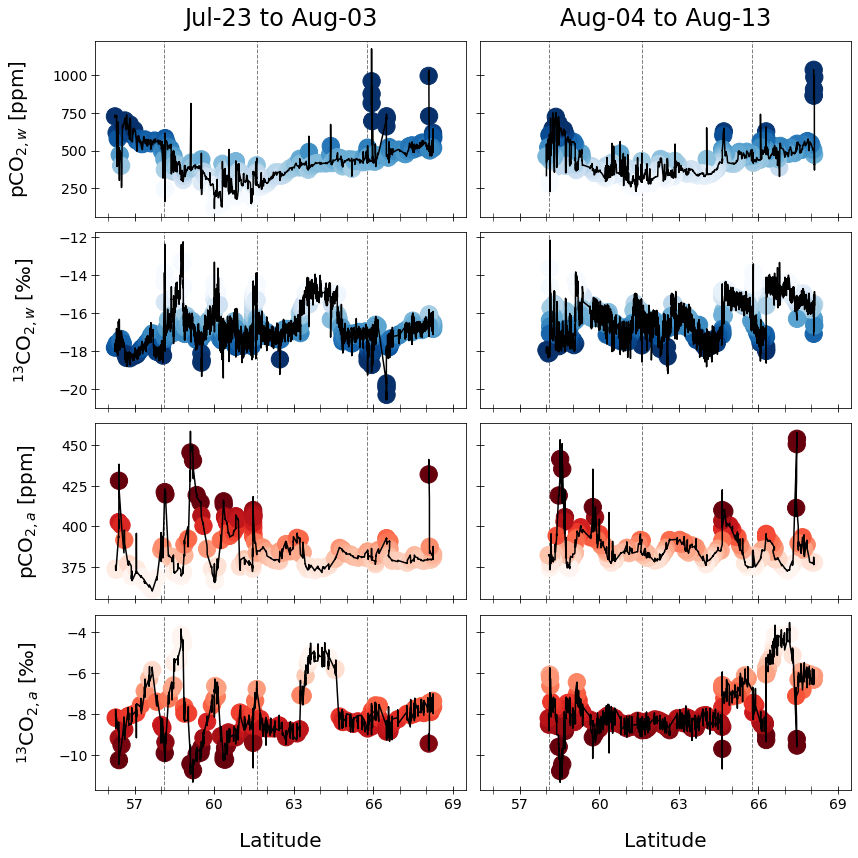

In [47]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")

ax[0,0].plot(df1w['lat_w'], df1w['co2_w'], c = 'black', lw=1.5)
ax[1,0].plot(df1w['lat_w'], df1w['ico2_w'], c = 'black', lw=1.5)
ax[2,0].plot(df1a['lat_a'], df1a['co2_a'], c = 'black', lw=1.5)
ax[3,0].plot(df1a['lat_a'], df1a['ico2_a'], c = 'black', lw=1.5)

ax[0,1].plot(df2w['lat_w'], df2w['co2_w'], c = 'black', lw=1.5)
ax[1,1].plot(df2w['lat_w'], df2w['ico2_w'], c = 'black', lw=1.5)
ax[2,1].plot(df2a['lat_a'], df2a['co2_a'], c = 'black', lw=1.5)
ax[3,1].plot(df2a['lat_a'], df2a['ico2_a'], c = 'black', lw=1.5)

ax[0,0].scatter(df1w_30T['lat_w'], df1w_30T['co2_w'], cmap = 'Blues', c = df1w_30T['co2_w'], 
                s=300, label="pCO$_{2,water}$", 
                vmin=df1w_30T['co2_w'].quantile(0.05), 
                vmax=df1w_30T['co2_w'].quantile(0.95))

ax[1,0].scatter(df1w_30T['lat_w'], df1w_30T['ico2_w'], cmap = 'Blues_r', c = df1w_30T['ico2_w'], 
                s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df1w_30T['ico2_w'].quantile(0.05), 
                vmax=df1w_30T['ico2_w'].quantile(0.95))

ax[2,0].scatter(df1a_30T['lat_a'], df1a_30T['co2_a'], cmap = 'Reds', c = df1a_30T['co2_a'], 
                s=300, label="pCO$_{2,air}$",
                vmin=df1a_30T['co2_a'].quantile(0.05), 
                vmax=df1a_30T['co2_a'].quantile(0.95))

ax[3,0].scatter(df1a_30T['lat_a'], df1a_30T['ico2_a'], cmap = 'Reds_r', c = df1a_30T['ico2_a'],
                s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df1a_30T['ico2_a'].quantile(0.05), 
                vmax=df1a_30T['ico2_a'].quantile(0.95))

ax[0,1].scatter(df2w_30T['lat_w'], df2w_30T['co2_w'], cmap = 'Blues', c = df2w_30T['co2_w'], 
                s=300, label="pCO$_{2,water}$", 
                vmin=df2w_30T['co2_w'].quantile(0.05), 
                vmax=df2w_30T['co2_w'].quantile(0.95))

ax[1,1].scatter(df2w_30T['lat_w'], df2w_30T['ico2_w'], cmap = 'Blues_r', c = df2w_30T['ico2_w'], 
                s=300, label="$^{13}$CO$_{2,water}$",
                vmin=df2w_30T['ico2_w'].quantile(0.05), 
                vmax=df2w_30T['ico2_w'].quantile(0.95))

ax[2,1].scatter(df2a_30T['lat_a'], df2a_30T['co2_a'], cmap = 'Reds', c = df2a_30T['co2_a'], 
                s=300, label="pCO$_{2,air}$",
                vmin=df2a_30T['co2_a'].quantile(0.05), 
                vmax=df2a_30T['co2_a'].quantile(0.95))

ax[3,1].scatter(df2a_30T['lat_a'], df2a_30T['ico2_a'], cmap = 'Reds_r', c = df2a_30T['ico2_a'], 
                lw=1, s=300, label="$^{13}$CO$_{2,air}$",
                vmin=df2a_30T['ico2_a'].quantile(0.05), 
                vmax=df2a_30T['ico2_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCO$_{2,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCO$_{2,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CO$_{2,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CO$_{2,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
    #ax.axvline(66.488333, color='grey', ls='--', lw=1, zorder=0)  # Kureyka
    #ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.tight_layout(pad=1)

fig.savefig('Yenisey_EDA_30T_co2_Latitude.png', dpi = 600, bbox_inches='tight')

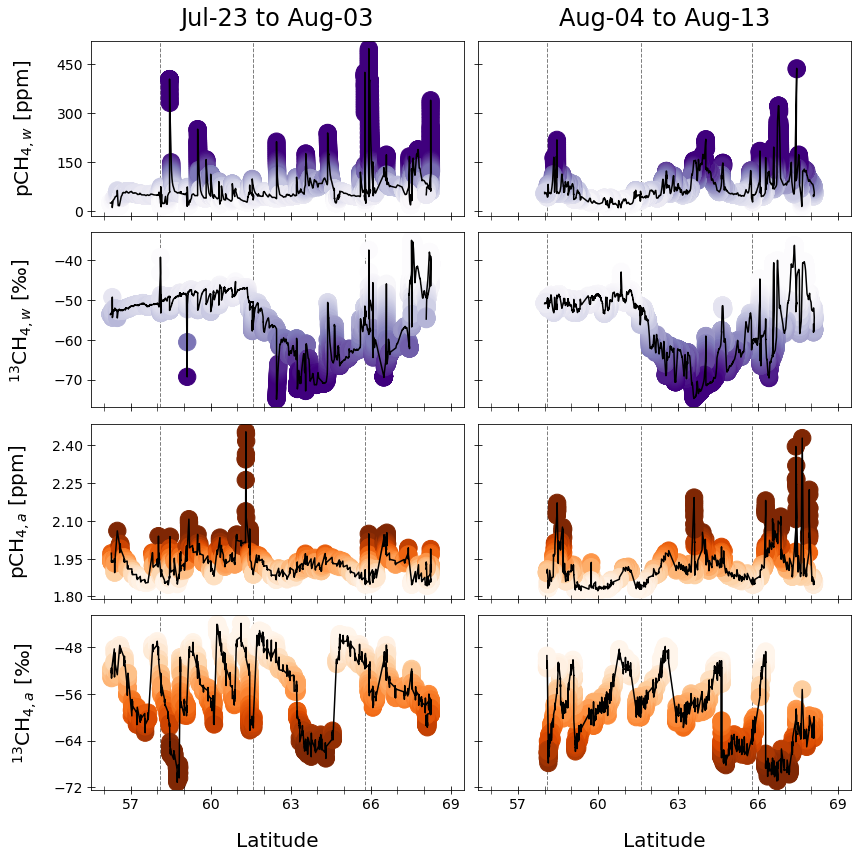

In [48]:
# Plot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey="row")

ax[0,0].plot(df1w['lat_w'], df1w['ch4_w'], c = 'black', lw=1.5)
ax[1,0].plot(df1w['lat_w'], df1w['ich4_w'], c = 'black', lw=1.5)
ax[2,0].plot(df1a['lat_a'], df1a['ch4_a'], c = 'black', lw=1.5)
ax[3,0].plot(df1a['lat_a'], df1a['ich4_a'], c = 'black', lw=1.5)

ax[0,1].plot(df2w['lat_w'], df2w['ch4_w'], c = 'black', lw=1.5)
ax[1,1].plot(df2w['lat_w'], df2w['ich4_w'], c = 'black', lw=1.5)
ax[2,1].plot(df2a['lat_a'], df2a['ch4_a'], c = 'black', lw=1.5)
ax[3,1].plot(df2a['lat_a'], df2a['ich4_a'], c = 'black', lw=1.5)

ax[0,0].scatter(df1w['lat_w'], df1w['ch4_w'], cmap = 'Purples', c = df1w['ch4_w'], 
                s=300, label="pCO$_{2,water}$", 
                vmin=df1w['ch4_w'].quantile(0.05), 
                vmax=df1w['ch4_w'].quantile(0.95))

ax[1,0].scatter(df1w['lat_w'], df1w['ich4_w'], cmap = 'Purples_r', c = df1w['ich4_w'], 
                s=300, label="$^{13}$CH$_{4,water}$",
                vmin=df1w['ich4_w'].quantile(0.05), 
                vmax=df1w['ich4_w'].quantile(0.95))

ax[2,0].scatter(df1a['lat_a'], df1a['ch4_a'], cmap = 'Oranges', c = df1a['ch4_a'], 
                s=300, label="pCO$_{2,air}$",
                vmin=df1a['ch4_a'].quantile(0.05), 
                vmax=df1a['ch4_a'].quantile(0.95))

ax[3,0].scatter(df1a['lat_a'], df1a['ich4_a'], cmap = 'Oranges_r', c = df1a['ich4_a'], 
                s=300, label="$^{13}$CH$_{4,air}$",
                vmin=df1a['ich4_a'].quantile(0.05), 
                vmax=df1a['ich4_a'].quantile(0.95))

ax[0,1].scatter(df2w['lat_w'], df2w['ch4_w'], cmap = 'Purples', c = df2w['ch4_w'], 
                s=300, label="pCO$_{2,water}$", 
                vmin=df2w['ch4_w'].quantile(0.05), 
                vmax=df2w['ch4_w'].quantile(0.95))

ax[1,1].scatter(df2w['lat_w'], df2w['ich4_w'], cmap = 'Purples_r', c = df2w['ich4_w'], 
                s=300, label="$^{13}$CH$_{4,water}$",
                vmin=df2w['ich4_w'].quantile(0.05), 
                vmax=df2w['ich4_w'].quantile(0.95))

ax[2,1].scatter(df2a['lat_a'], df2a['ch4_a'], cmap = 'Oranges', c = df2a['ch4_a'], 
                s=300, label="pCO$_{2,air}$",
                vmin=df2a['ch4_a'].quantile(0.05), 
                vmax=df2a['ch4_a'].quantile(0.95))

ax[3,1].scatter(df2a['lat_a'], df2a['ich4_a'], cmap = 'Oranges_r', c = df2a['ich4_a'], 
                s=300, label="$^{13}$CH$_{4,air}$",
                vmin=df2a['ich4_a'].quantile(0.05), 
                vmax=df2a['ich4_a'].quantile(0.95))

ax[0,0].set_title('Jul-23 to Aug-03', fontsize=24, c='black', pad=15)
ax[0,1].set_title('Aug-04 to Aug-13', fontsize=24, c='black', pad=15)
ax[0,0].set_ylabel('pCH$_{4,w}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[2,0].set_ylabel('pCH$_{4,a}$ [ppm]', color='black', fontsize=20, labelpad=20)
ax[1,0].set_ylabel('$^{13}$CH$_{4,w}$ [‰]', color='black', fontsize=20, labelpad=18)
ax[3,0].set_ylabel('$^{13}$CH$_{4,a}$ [‰]', color='black', fontsize=20, labelpad=15)
ax[3,0].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)
ax[3,1].set_xlabel('Latitude', color='black', fontsize=20, labelpad=20)

for ax in ax.flat:
    ax.set_xlim(55.5, 69.5)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_tick_params(which='major',direction='inout',length=8,labelsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(3))
    ax.xaxis.set_tick_params(direction='inout', length=8, labelsize=14)
    ax.xaxis.set_tick_params(which='minor', direction='inout',length=8, labelsize=14)
    ax.axvline(58.10, color='grey', ls='--', lw=1, zorder=0)  # Angara
    ax.axvline(61.60, color='grey', ls='--', lw=1, zorder=0)  # PT
    ax.axvline(65.77, color='grey', ls='--', lw=1, zorder=0)  # NT
    #ax.axvline(66.488333, color='grey', ls='--', lw=1, zorder=0)  # Kureyka
    #ax.axvline(67.44, color='grey', ls='--', lw=1.2, zorder=0) # Igarka

fig.tight_layout(pad=1)

fig.savefig('Yenisey_EDA_30T_ch4_Latitude.png', dpi = 600, bbox_inches='tight')